# ACT2023 Tutorial Sessions - exercises part 3
init draft: 07 Aug 2023 \
last update: 09 Aug 2023

Ref: \
https://act2023tutorials.netlify.app/algebraicjulia/exercises \
https://act2023tutorials.netlify.app/algebraicjulia/solutions

## Exercise (Your first DDS).
DDS: discrete dynamical systems

In [1]:
using Catlab
@present SchDDS(FreeSchema) begin
  X::Ob
  ϕ::Hom(X,X)
end

@acset_type DDS(SchDDS)

DDS

In [2]:
using Catlab

myDDS = DDS()
add_parts!(myDDS, :X, 5, ϕ=[3,3,4,1,2])
myDDS

X,ϕ
1,3
2,3
3,4
4,1
5,2


We could alternatively make use of the @acset macro. This lets us specify an instance declaratively.

In [3]:
using Catlab

myDDS = @acset DDS begin
  X = 5
  ϕ = [3,3,4,1,2]
end
myDDS

X,ϕ
1,3
2,3
3,4
4,1
5,2


## Exercise (Double nested undirected wiring diagram)
AlgebraicDynamics.jl/test/uwd_dynam.jl : \
https://github.com/AlgebraicJulia/AlgebraicDynamics.jl/blob/43989a4035b315b61676034a63c4ad5d5b4086bf/test/uwd_dynam.jl#L158


In [4]:
using AlgebraicDynamics.UWDDynam
using Catlab

using Test

const UWD = UndirectedWiringDiagram

@testset "UWDDynam" begin
  dx(x, p, t) = [x[1]^2, 2*x[1]-x[2]]
  dy(y, p, t) = [1 - y[1]^2]

  r = ContinuousResourceSharer{Float64}(2, dx)
  s = ContinuousResourceSharer{Float64}(1, dy)
  t = ContinuousResourceSharer{Float64}(1, 2, dx, [2])
  @test all(eltype.([r, s, t]) .== Float64)

  x0 = [10.0, 7.5]

  @testset "Identity & merge" begin
    d = @relation (x,y) begin
      f(x,y)
    end
    r2 = oapply(d, [r])

    @test nstates(r) == nstates(r2)
    @test nports(r) == nports(r2)
    @test portmap(r) == portmap(r2)
    @test eval_dynamics(r, x0) == eval_dynamics(r2, x0)
    @test exposed_states(r, x0) == exposed_states(r2, x0)
    @test ports(r) == [1, 2]
    @test ports(r2) == [:x, :y]

    h = 0.1
    drs = oapply(d, [euler_approx(r, h)])
    drs2 = euler_approx(r2, h)
    @test eval_dynamics(drs, x0) == eval_dynamics(drs2, x0)
    drs3 = euler_approx(r2)
    drs4 = oapply(d, [euler_approx(r)])
    @test eval_dynamics(drs, x0) == eval_dynamics(drs3, x0, [h])
    @test eval_dynamics(drs, x0) == eval_dynamics(drs4, x0, [h])

    d = @relation (x,) begin
      f(x,x)
    end
    r2 = oapply(d, [r])

    @test nstates(r2) == 1
    @test nports(r2) == 1
    @test portmap(r2) == [1]
    @test eval_dynamics(r2, [5.0]) == [30.0]
    @test exposed_states(r2, [5.0]) == [5.0]
    @test ports(r2) == [:x]

    let r = ContinuousResourceSharer{Float64}(2, (u,p,t) -> [u[1]*p[1], u[2]*p[2] + t])
    r2 = oapply(d, [r])
    @test eval_dynamics(r2, [5.0], [1.0, 2.0], 10.0) == [25.0]
    end
  end

  @testset "Copy" begin
    d = UWD(2)
    add_box!(d, 1)
    add_junctions!(d, 1)
    set_junction!(d, [1])
    set_junction!(d, [1,1], outer = true)

    let r = t
    r2 = oapply(d, r)
    @test nstates(r2) == 2
    @test nports(r2) == 2
    @test portmap(r2) == [2,2]
    @test eval_dynamics(r2, x0) == eval_dynamics(r, x0)
    @test exposed_states(r2, x0) == [x0[2], x0[2]]
    end
  end
  
  @testset "Copy & merge" begin
    d = @relation (x,) begin
      f(x,x)
    end

    let r = ContinuousResourceSharer{Float64}(2, 2, dx, [1,1])
    r2 = oapply(d, r)
    @test nstates(r2) == 2
    @test nports(r2) == 1
    @test ports(r2) == [:x]
    @test portmap(r2) == [1]
    @test eval_dynamics(r2, x0) == eval_dynamics(r, x0)
    @test exposed_states(r2, x0) == [x0[1]]
    end
  end

  @testset "Duplicate & add state" begin
    let r = s
    rcopy = ContinuousResourceSharer{Float64}(2, 1, dy, [1,1])
    d = HypergraphDiagram{Nothing, Symbol}(2)
    add_box!(d, 1, name = :r); add_box!(d, 2, name = :copy); add_box!(d, 1, name = :r)
    add_junctions!(d, 2)
    set_junction!(d, [1,1,2,2])
    set_junction!(d, [1,2], outer = true)
    xs = Dict(:r => r, :copy => rcopy)
    r2 = oapply(d, xs)
    @test nstates(r2) == 1
    @test nports(r2) == 2
    @test portmap(r2) == [1,1]
    @test eval_dynamics(r2, [7.0]) == [3 *(1 - 7.0^2)]
    @test exposed_states(r2, [7.0]) == [7.0, 7.0]

    d = UWD(2)
    add_box!(d, 1)
    add_junctions!(d, 2)
    set_junction!(d, [1])
    set_junction!(d, [1,2], outer = true)
    r2 = oapply(d, [r])
    @test nstates(r2) == 2
    @test nports(r2) == 2
    @test portmap(r2) == [1,2]
    @test eval_dynamics(r2, [7.0, 11.0]) == [-48.0, 0.0]
    @test exposed_states(r2, [7.0, 11.0]) == [7.0, 11.0]
    end
  end

  @testset "Boxes" begin
    xs = Dict(:r => r, :s => s)
    d = HypergraphDiagram{Nothing, Symbol}(5)
    add_box!(d, 2, name = :r); add_box!(d, 1, name = :s); add_box!(d, 2, name = :r)
    add_junctions!(d, 4)
    set_junction!(d, [1,1,1,4,2])
    set_junction!(d, [1,1,2,3,3], outer = true)
    r2 = oapply(d, xs)
    @test nstates(r2) == 4
    @test nports(r2) == 5
    @test portmap(r2) == [1,1, 3, 4,4]
    x0 = [2.0, 7.0, 3.0, 5.0]
    @test eval_dynamics(r2, x0) == [3.0, 49.0, 11.0, 0.0]
    @test exposed_states(r2, x0) == [2.0, 2.0, 3.0, 5.0, 5.0]

    h = 0.1
    dr = oapply(d, euler_approx([r,s,r], h))
    dr2 = euler_approx(r2, h)
    dr3 = oapply(d, euler_approx([r,s,r]))
    dr4 = euler_approx(r2)
    @test eval_dynamics(dr, x0) == [2.3, 11.9, 4.1, 5.0]
    @test eval_dynamics(dr, x0) == eval_dynamics(dr2, x0)
    @test eval_dynamics(dr, x0) == eval_dynamics(dr3, x0, [h], 0)
    @test eval_dynamics(dr, x0) == eval_dynamics(dr4, x0, [h], 0)

    h = 0.25
    dr = oapply(d, euler_approx(xs, h))
    dr2 = euler_approx(r2, h)
    dr3 = oapply(d, euler_approx(xs))
    dr4 = euler_approx(r2)
    @test eval_dynamics(dr, x0) == eval_dynamics(dr2, x0)
    @test eval_dynamics(dr, x0) == eval_dynamics(dr3, x0, [h], 0)
    @test eval_dynamics(dr, x0) == eval_dynamics(dr4, x0, [h], 0)
  end

  @testset "Commutativity: substitute & oapply" begin
    d = UWD(4)
    add_box!(d, 1); add_box!(d, 2)
    add_junctions!(d, 3)
    set_junction!(d, [1,2,1])
    set_junction!(d, [1,2,3,3], outer = true)

    din = UWD(2)
    add_box!(din, 1); add_box!(din, 2)
    add_junctions!(din, 2)
    set_junction!(din, [1,1,2])
    set_junction!(din, [1,2], outer = true)

    dtot = ocompose(d, 2, din)

    let s = t
    r1 = oapply(dtot, [s,s,r])
    r2 = oapply(d, [s, oapply(din, [s,r])])

    @test nstates(r1) == nstates(r2)
    @test nports(r1) == nports(r2)
    @test portmap(r1) == portmap(r2)
    x0 = [2.0, 3.0, 5.0, 7.0, 11.0]
    @test eval_dynamics(r1, x0) == eval_dynamics(r2, x0)
    end
  end
end


Test Summary: | Pass  Total   Time
UWDDynam      |   55     55  14.4s


Test.DefaultTestSet("UWDDynam", Any[Test.DefaultTestSet("Identity & merge", Any[], 17, false, false, true, 1.691612281039687e9, 1.691612287821762e9, false), Test.DefaultTestSet("Copy", Any[], 5, false, false, true, 1.691612287821804e9, 1.691612288709638e9, false), Test.DefaultTestSet("Copy & merge", Any[], 6, false, false, true, 1.691612288709666e9, 1.691612288719761e9, false), Test.DefaultTestSet("Duplicate & add state", Any[], 10, false, false, true, 1.691612288719779e9, 1.691612290634128e9, false), Test.DefaultTestSet("Boxes", Any[], 12, false, false, true, 1.69161229063415e9, 1.691612291089759e9, false), Test.DefaultTestSet("Commutativity: substitute & oapply", Any[], 4, false, false, true, 1.691612291089784e9, 1.691612295155382e9, false)], 1, false, false, true, 1.691612280732855e9, 1.691612295155389e9, false)

## Exercise (Petri nets as dynamic systems)

In [9]:
# import Pkg; Pkg.add("AlgebraicPetri")
import Pkg; Pkg.add("OrdinaryDiffEq")

   Resolving package versions...
    Updating `~/.julia/environments/v1.9/Project.toml`
  [1dea7af3] + OrdinaryDiffEq v6.53.4
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


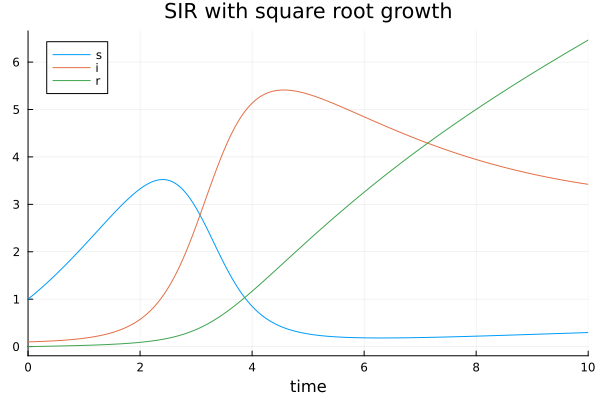

In [11]:
using AlgebraicPetri, AlgebraicDynamics.UWDDynam

using OrdinaryDiffEq
using Plots

function ContinuousResourceSharer{T}(pn::AbstractPetriNet) where {T}
  vf! = vectorfield(pn)
  vf(u, p, t) = vf!(zero(u), u, p, t)
  ContinuousResourceSharer{T}(ns(pn), vf)
end

sir_petri = PetriNet(LabelledPetriNet([:S,:I,:R], :inf=>((:S,:I)=>(:I,:I)), :rec=>(:I=>:R)))

sir_sharer = ContinuousResourceSharer{Float64}(sir_petri)

birth = ContinuousResourceSharer{Float64}(1, (u, p, t) -> sqrt(u[1]))

uwd = @relation (s,i,r) where (s,i,r) begin
  SIR(s,i,r)
  Birth(s)
end

sys = oapply(uwd, [sir_sharer, birth])

u0 = [1.0, 0.1, 0]
params = [0.5, 0.2]
tspan = (0.0, 10.0)

prob = ODEProblem(sys, u0, tspan, params)
sol = solve(prob, Tsit5())
plot(sol, title="SIR with square root growth", xlabel="time", label=["s" "i" "r"])

## Exercise (Lotka-Volterra with a twist)

In [12]:
using AlgebraicDynamics.UWDDynam
using Catlab
using Plots

# Return a continuous resource sharer describing the interaction
# of a predator and prey based on predation rate and growth rate parameters.
function binary_predation_system(growth_rate, predation_rate)
    dynamics(u,_,_) = [
        # The predators can reproduce if there are at least 2 of them.
        u[1] >= 2 ? growth_rate*u[1]*u[2] : 0,
        # The predators cannot eat if there aren't at least 1 of them.
        u[1] > 1 ? -predation_rate*u[1]*u[2] : 0
    ]
    return ContinuousResourceSharer{Float64}(2, dynamics)
end

binary_predation_system (generic function with 1 method)

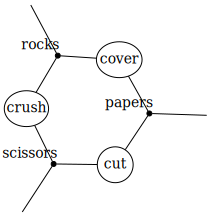

In [13]:
d = @relation (rocks, papers, scissors) begin
    crush(rocks, scissors)
    cover(papers, rocks)
    cut(scissors, papers)
end

to_graphviz(d, box_labels = :name, junction_labels = :variable, edge_attrs=Dict(:len => ".75"))

In [14]:
crush_rate = .2
cover_rate = .1
cut_rate = .3

rock_reproduction_rate = 0.1
paper_reproduction_rate = 0.2
scissor_reproduction_rate = 0.1

subsystems = Dict(
    :crush => binary_predation_system(rock_reproduction_rate, crush_rate),
    :cover => binary_predation_system(paper_reproduction_rate, cover_rate),
    :cut => binary_predation_system(scissor_reproduction_rate, cut_rate)
)

rps_system = oapply(d, subsystems)

ContinuousResourceSharer(ℝ^3 → ℝ^3) with 3 exposed ports

┌ Warning: To maintain consistency with solution indexing, keyword argument vars will be removed in a future version. Please use keyword argument idxs instead.
│   caller = ip:0x0
└ @ Core :-1


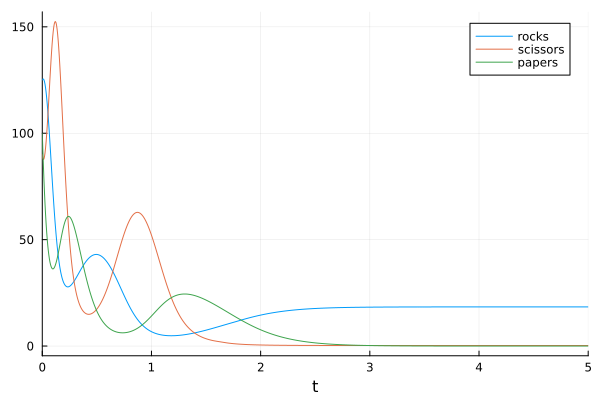

In [15]:
using OrdinaryDiffEq

u0 = [125.0, 100.0, 90.0]
tspan = (0.0,5.0)

prob = ODEProblem(rps_system, u0, tspan)
sol = solve(prob, Tsit5())

plot(sol, rps_system)